# Imports e inicio sesion spark

In [47]:
import random
import math
from operator import add
import numpy as np
import time
import findspark
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, Bucketizer, VectorAssembler
from pyspark.ml.stat import Correlation
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as ply
import seaborn as sns

In [49]:
findspark.init()
spark = SparkSession.builder \
    .appName("Cargar CSV a DataFrame") \
    .getOrCreate()

# Carga de datos

In [50]:
#flightsDF = spark.read.csv("abfss://upmpractica-fs@upmdatalake.dfs.core.windows.net/synapse/workspaces/upmpractica-ws/data/flights_jan08.csv", header=True, inferSchema=True)
flightsDF = spark.read.option("header", "true")\
                      .option("inferSchema", "true")\
                      .csv("flights_jan08.csv")

In [51]:
flightsDF.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Ca

In [52]:
flightsDF.select(flightsDF.columns[:6]).show(3)
flightsDF.select(flightsDF.columns[:6]).summary().show()

+----+-----+----------+---------+-------+----------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|
+----+-----+----------+---------+-------+----------+
|2008|    1|         3|        4|   2003|      1955|
|2008|    1|         3|        4|    754|       735|
|2008|    1|         3|        4|    628|       620|
+----+-----+----------+---------+-------+----------+
only showing top 3 rows



+-------+------+------+-----------------+------------------+-----------------+------------------+
|summary|  Year| Month|       DayofMonth|         DayOfWeek|          DepTime|        CRSDepTime|
+-------+------+------+-----------------+------------------+-----------------+------------------+
|  count|100000|100000|           100000|            100000|           100000|            100000|
|   mean|2008.0|   1.0|         17.08786|           3.89004|1355.200722248073|         1341.9894|
| stddev|   0.0|   0.0|8.356363976550366|1.9529994727263522|464.0896318178077|451.35698421417186|
|    min|  2008|     1|                1|                 1|                1|               600|
|    25%|  2008|     1|               10|                 2|            942.0|               940|
|    50%|  2008|     1|               17|                 4|           1344.0|              1335|
|    75%|  2008|     1|               24|                 5|           1743.0|              1730|
|    max|  2008|    

In [53]:
flightsDF.select(flightsDF.columns[6:12]).show(3)
flightsDF.select(flightsDF.columns[6:12]).summary().show()

+-------+----------+-------------+---------+-------+-----------------+
|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|
+-------+----------+-------------+---------+-------+-----------------+
|   2211|      2225|           WN|      335| N712SW|              128|
|   1002|      1000|           WN|     3231| N772SW|              128|
|    804|       750|           WN|      448| N428WN|               96|
+-------+----------+-------------+---------+-------+-----------------+
only showing top 3 rows



+-------+------------------+------------------+-------------+------------------+-------+------------------+
|summary|           ArrTime|        CRSArrTime|UniqueCarrier|         FlightNum|TailNum| ActualElapsedTime|
+-------+------------------+------------------+-------------+------------------+-------+------------------+
|  count|            100000|            100000|       100000|            100000|  98858|            100000|
|   mean|1492.7392247056678|        1502.60154|         null|        1510.64854|   null|107.55850169203023|
| stddev| 496.3767939169903|478.10021559061414|         null|1186.1285980391729|   null|    55.35097080091|
|    min|                 1|                 5|           WN|                 1| N11109|               100|
|    25%|            1114.0|              1120|         null|               502|   null|              68.0|
|    50%|            1518.0|              1520|         null|              1320|   null|              88.0|
|    75%|            1913.0|

In [54]:
flightsDF.select(flightsDF.columns[12:18]).show(3)
flightsDF.select(flightsDF.columns[12:18]).summary().show()

+--------------+-------+--------+--------+------+----+
|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|
+--------------+-------+--------+--------+------+----+
|           150|    116|     -14|       8|   IAD| TPA|
|           145|    113|       2|      19|   IAD| TPA|
|            90|     76|      14|       8|   IND| BWI|
+--------------+-------+--------+--------+------+----+
only showing top 3 rows



+-------+-----------------+-----------------+-----------------+------------------+------+------+
|summary|   CRSElapsedTime|          AirTime|         ArrDelay|          DepDelay|Origin|  Dest|
+-------+-----------------+-----------------+-----------------+------------------+------+------+
|  count|           100000|           100000|           100000|            100000|100000|100000|
|   mean|        111.98954| 91.8637966321506|5.729954001094247|10.379048736571649|  null|  null|
| stddev|57.20913510480459|54.20822434609592|30.96695927246462|28.384428068170866|  null|  null|
|    min|               17|              100|               -1|                -1|   ABQ|   ABQ|
|    25%|               70|             53.0|             -9.0|              -2.0|  null|  null|
|    50%|               90|             71.0|             -2.0|               1.0|  null|  null|
|    75%|              145|            118.0|             10.0|              10.0|  null|  null|
|    max|              370|   

In [55]:
flightsDF.select(flightsDF.columns[18:23]).show(3)
flightsDF.select(flightsDF.columns[18:23]).summary().show()

+--------+------+-------+---------+----------------+
|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|
+--------+------+-------+---------+----------------+
|     810|     4|      8|        0|            null|
|     810|     5|     10|        0|            null|
|     515|     3|     17|        0|            null|
+--------+------+-------+---------+----------------+
only showing top 3 rows



+-------+-----------------+-----------------+------------------+-------------------+----------------+
|summary|         Distance|           TaxiIn|           TaxiOut|          Cancelled|CancellationCode|
+-------+-----------------+-----------------+------------------+-------------------+----------------+
|  count|           100000|           100000|            100000|             100000|            1142|
|   mean|        630.58632|4.768961883726114|10.927765077181412|            0.01142|            null|
| stddev|437.3570752611293|2.983635448088949| 5.989579591427709|0.10625298347324127|            null|
|    min|               66|                1|                 1|                  0|               A|
|    25%|              324|              3.0|               8.0|                  0|            null|
|    50%|              453|              4.0|               9.0|                  0|            null|
|    75%|              843|              5.0|              12.0|                  

In [56]:
flightsDF.select(flightsDF.columns[23:28]).show(3)
flightsDF.select(flightsDF.columns[23:28]).summary().show()

+--------+------------+------------+--------+-------------+
|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|
+--------+------------+------------+--------+-------------+
|       0|          NA|          NA|      NA|           NA|
|       0|          NA|          NA|      NA|           NA|
|       0|          NA|          NA|      NA|           NA|
+--------+------------+------------+--------+-------------+
only showing top 3 rows



+-------+------------------+-----------------+------------------+-----------------+-------------------+
|summary|          Diverted|     CarrierDelay|      WeatherDelay|         NASDelay|      SecurityDelay|
+-------+------------------+-----------------+------------------+-----------------+-------------------+
|  count|            100000|           100000|            100000|           100000|             100000|
|   mean|            0.0016|9.573488206225482|2.0361200264914157|8.353150950124816|0.11080544092923736|
| stddev|0.0399681870311844|21.83683640672927|13.815867838905518|18.82608664849725| 1.7248882167846213|
|    min|                 0|                0|                 0|                0|                  0|
|    25%|                 0|              0.0|               0.0|              0.0|                0.0|
|    50%|                 0|              1.0|               0.0|              0.0|                0.0|
|    75%|                 0|             11.0|               0.0


[Stage 349:>                                                        (0 + 1) / 1]



In [57]:
flightsDF.select(flightsDF.columns[28:]).show(3)
flightsDF.select(flightsDF.columns[28:]).summary().show()

+-----------------+
|LateAircraftDelay|
+-----------------+
|               NA|
|               NA|
|               NA|
+-----------------+
only showing top 3 rows



+-------+-----------------+
|summary|LateAircraftDelay|
+-------+-----------------+
|  count|           100000|
|   mean|29.34367517448673|
| stddev|39.75352889072861|
|    min|                0|
|    25%|              1.0|
|    50%|             18.0|
|    75%|             37.0|
|    max|               NA|
+-------+-----------------+



In [58]:
num_filas = flightsDF.count()
print("Número de filas:", num_filas)
print("Número de columnas:", len(flightsDF.columns))

Número de filas: 100000
Número de columnas: 29


El dataset está compuesto por las siguientes variables:

1. **Year** 2008
2. **Month** 1
3. **DayofMonth** 1-31
4. **DayOfWeek** 1 (Monday) - 7 (Sunday)
5. **DepTime** hora real de salida (local, hhmm)
6. **CRSDepTime** hora prevista de salida (local, hhmm)
7. **ArrTime** hora real de llegada (local, hhmm)
8. **CRSArrTime** hora prevista de llegada (local, hhmm)
9. **UniqueCarrier** código del aparato
10. **FlightNum** número de vuelo
11. **TailNum** identificador de cola: aircraft registration, unique aircraft identifier
12. **ActualElapsedTime** tiempo real invertido en el vuelo
13. **CRSElapsedTime** en minutos
14. **AirTime** en minutos
15. **ArrDelay** retraso a la llegada, en minutos: se considera que un vuelo ha llegado "on time" si aterrizó menos de 15 minutos más tarde de la hora prevista en el Computerized Reservations Systems (CRS).
16. **DepDelay** retraso a la salida, en minutos
17. **Origin** código IATA del aeropuerto de origen
18. **Dest** código IATA del aeropuerto de destino
19. **Distance** en millas
20. **TaxiIn** taxi in time, in minutes
21. **TaxiOut** taxi out time in minutes
22. **Cancelled** *si el vuelo fue cancelado (1 = sí, 0 = no)
23. **CancellationCode** razón de cancelación (A = aparato, B = tiempo atmosférico, C = NAS, D = seguridad)
24. **Diverted** *si el vuelo ha sido desviado (1 = sí, 0 = no)
25. **CarrierDelay** en minutos: El retraso del transportista está bajo el control del transportista aéreo. Ejemplos de sucesos que pueden determinar el retraso del transportista son: limpieza de la aeronave, daño de la aeronave, espera de la llegada de los pasajeros o la tripulación de conexión, equipaje, impacto de un pájaro, carga de equipaje, servicio de comidas, computadora, equipo del transportista, problemas legales de la tripulación (descanso del piloto o acompañante) , daños por mercancías peligrosas, inspección de ingeniería, abastecimiento de combustible, pasajeros discapacitados, tripulación retrasada, servicio de inodoros, mantenimiento, ventas excesivas, servicio de agua potable, denegación de viaje a pasajeros en mal estado, proceso de embarque muy lento, equipaje de mano no válido, retrasos de peso y equilibrio.
26. **WeatherDelay** en minutos: causado por condiciones atmosféricas extremas o peligrosas, previstas o que se han manifestado antes del despegue, durante el viaje, o a la llegada.
27. **NASDelay** en minutos: retraso causado por el National Airspace System (NAS) por motivos como condiciones meteorológicas (perjudiciales pero no extremas), operaciones del aeropuerto, mucho tráfico aéreo, problemas con los controladores aéreos, etc.
28. **SecurityDelay** en minutos: causado por la evacuación de una terminal, re-embarque de un avión debido a brechas en la seguridad, fallos en dispositivos del control de seguridad, colas demasiado largas en el control de seguridad, etc.
29. **LateAircraftDelay** en minutos: debido al propio retraso del avión al llegar, problemas para conseguir aterrizar en un aeropuerto a una hora más tardía de la que estaba prevista.

In [59]:
null_counts = [flightsDF.where(F.col(c).isNull()).count() for c in flightsDF.columns]

na_counts = [flightsDF.where(F.col(c) == "NA").count() for c in flightsDF.columns]

for i, col_name in enumerate(flightsDF.columns):
    print(f"Columna '{col_name}': Valores nulos: {null_counts[i]}, Valores NA: {na_counts[i]}")

Columna 'Year': Valores nulos: 0, Valores NA: 0
Columna 'Month': Valores nulos: 0, Valores NA: 0
Columna 'DayofMonth': Valores nulos: 0, Valores NA: 0
Columna 'DayOfWeek': Valores nulos: 0, Valores NA: 0
Columna 'DepTime': Valores nulos: 0, Valores NA: 1142
Columna 'CRSDepTime': Valores nulos: 0, Valores NA: 0
Columna 'ArrTime': Valores nulos: 0, Valores NA: 1302
Columna 'CRSArrTime': Valores nulos: 0, Valores NA: 0
Columna 'UniqueCarrier': Valores nulos: 0, Valores NA: 0
Columna 'FlightNum': Valores nulos: 0, Valores NA: 0
Columna 'TailNum': Valores nulos: 1142, Valores NA: 0
Columna 'ActualElapsedTime': Valores nulos: 0, Valores NA: 1302
Columna 'CRSElapsedTime': Valores nulos: 0, Valores NA: 0
Columna 'AirTime': Valores nulos: 0, Valores NA: 1302
Columna 'ArrDelay': Valores nulos: 0, Valores NA: 1302
Columna 'DepDelay': Valores nulos: 0, Valores NA: 1142
Columna 'Origin': Valores nulos: 0, Valores NA: 0
Columna 'Dest': Valores nulos: 0, Valores NA: 0
Columna 'Distance': Valores nulo

# Limpieza de los datos

Pese a tener un gran número de diferentes datos y columnas, la gran mayoría son inútiles para la tarea que queremos realizar.

Procedemos a crear un nuevo dataset con los datos que nos interesan, que son:
**DayOfWeek**, **TailNum**, **Origin**, **Dest**, **DepTime**, **DepDelay**, **ArrTime** y **ArrDelay** (la cual será la variable objetivo a predecir).

Además, procedemos a eliminar las filas que contengan datos faltantes (NA) y las convertimos a tipo Integer.

In [142]:
cols_to_delete = ["Distance","WeatherDelay","NASDelay", "SecurityDelay", "LateAircraftDelay", "CarrierDelay"]
all_cols = ["DayOfWeek", "TailNum", "Origin", "Dest", "DepTime", "DepDelay", "ArrTime", "ArrDelay", *cols_to_delete]
int_cols = ["DayOfWeek", "DepTime", "DepDelay", "ArrTime", "ArrDelay", *cols_to_delete]

In [143]:
explFlightsDF = flightsDF.filter(F.col("Cancelled") == 0).select(*all_cols)\
                          .where("ArrDelay != 'NA' and DepDelay != 'NA' and DepTime != 'NA' and ArrTime != 'NA' and TailNum != 'NA'")\

for col in int_cols:
    explFlightsDF = explFlightsDF.withColumn(col, F.col(col).cast(IntegerType()))


cleanFlightsDF = explFlightsDF.drop(*cols_to_delete)

In [144]:
cleanFlightsDF.printSchema()
explFlightsDF.printSchema()

root
 |-- DayOfWeek: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)

root
 |-- DayOfWeek: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- WeatherDelay: integer (nullable = true)
 |-- NASDelay: integer (nullable = true)
 |-- SecurityDelay: integer (nullable = true)
 |-- LateAircraftDelay: integer (nullable = true)
 |-- CarrierDelay: integer (nullable = true)



In [145]:
cleanFlightsDF.show(3)

+---------+-------+------+----+-------+--------+-------+--------+
|DayOfWeek|TailNum|Origin|Dest|DepTime|DepDelay|ArrTime|ArrDelay|
+---------+-------+------+----+-------+--------+-------+--------+
|        4| N712SW|   IAD| TPA|   2003|       8|   2211|     -14|
|        4| N772SW|   IAD| TPA|    754|      19|   1002|       2|
|        4| N428WN|   IND| BWI|    628|       8|    804|      14|
+---------+-------+------+----+-------+--------+-------+--------+
only showing top 3 rows



In [146]:
cleanFlightsDF.summary().show()

+-------+------------------+-------+------+-----+------------------+-----------------+------------------+-----------------+
|summary|         DayOfWeek|TailNum|Origin| Dest|           DepTime|         DepDelay|           ArrTime|         ArrDelay|
+-------+------------------+-------+------+-----+------------------+-----------------+------------------+-----------------+
|  count|             98698|  98698| 98698|98698|             98698|            98698|             98698|            98698|
|   mean| 3.892956290907617|   null|  null| null|1355.0917647774017|10.33054367869663|1492.7392247056678|5.729954001094247|
| stddev|1.9547814932045984|   null|  null| null| 464.0457652563075|28.25640518188244| 496.3767939169903|30.96695927246462|
|    min|                 1| N11109|   ABQ|  ABQ|                 1|              -44|                 1|              -57|
|    25%|                 2|   null|  null| null|               942|               -2|              1114|               -9|
|    50%

In [147]:
null_counts = [explFlightsDF.where(F.col(c).isNull()).count() for c in explFlightsDF.columns]

na_counts = [explFlightsDF.where(F.col(c) == "NA").count() for c in explFlightsDF.columns]

for i, col_name in enumerate(explFlightsDF.columns):
    print(f"Columna '{col_name}': Valores nulos: {null_counts[i]}, Valores NA: {na_counts[i]}")

Columna 'DayOfWeek': Valores nulos: 0, Valores NA: 0
Columna 'TailNum': Valores nulos: 0, Valores NA: 0
Columna 'Origin': Valores nulos: 0, Valores NA: 0
Columna 'Dest': Valores nulos: 0, Valores NA: 0
Columna 'DepTime': Valores nulos: 0, Valores NA: 0
Columna 'DepDelay': Valores nulos: 0, Valores NA: 0
Columna 'ArrTime': Valores nulos: 0, Valores NA: 0
Columna 'ArrDelay': Valores nulos: 0, Valores NA: 0
Columna 'Distance': Valores nulos: 0, Valores NA: 0
Columna 'WeatherDelay': Valores nulos: 79069, Valores NA: 0
Columna 'NASDelay': Valores nulos: 79069, Valores NA: 0
Columna 'SecurityDelay': Valores nulos: 79069, Valores NA: 0
Columna 'LateAircraftDelay': Valores nulos: 79069, Valores NA: 0
Columna 'CarrierDelay': Valores nulos: 79069, Valores NA: 0


In [148]:
num_filas = explFlightsDF.count()
print("Número de filas:", num_filas)
print("Número de columnas:", len(cleanFlightsDF.columns))

Número de filas: 98698
Número de columnas: 8


In [149]:
org_dest = explFlightsDF.select("Origin").union(explFlightsDF.select(F.col("Dest").alias("Origin"))).distinct()

indexer = StringIndexer(inputCol="Origin", outputCol="index")
org_dest_indexer = indexer.fit(org_dest).transform(org_dest)

#org_dest_indexer = org_dest_indexer.withColumn("index", F.col("index").cast(IntegerType()))
#org_dest_indexer.show(3)

explFlightsDF_indexes_origin = explFlightsDF.join(org_dest_indexer, "Origin", "left").withColumnRenamed("index","index_origin")

# explFlightsDF_indexes_origin.show()

explFlightsDF_indexes_origin_dest = explFlightsDF_indexes_origin.join(org_dest_indexer.withColumnRenamed("Origin","Dest"), "Dest", "left").withColumnRenamed("index","index_dest")
explFlightsDF_indexes_origin_dest.show(5)

+----+------+---------+-------+-------+--------+-------+--------+--------+------------+--------+-------------+-----------------+------------+------------+----------+
|Dest|Origin|DayOfWeek|TailNum|DepTime|DepDelay|ArrTime|ArrDelay|Distance|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|CarrierDelay|index_origin|index_dest|
+----+------+---------+-------+-------+--------+-------+--------+--------+------------+--------+-------------+-----------------+------------+------------+----------+
| TPA|   IAD|        4| N712SW|   2003|       8|   2211|     -14|     810|        null|    null|         null|             null|        null|        35.0|      86.0|
| TPA|   IAD|        4| N772SW|    754|      19|   1002|       2|     810|        null|    null|         null|             null|        null|        35.0|      86.0|
| BWI|   IND|        4| N428WN|    628|       8|    804|      14|     515|        null|    null|         null|             null|        null|        37.0|      13.0|
| BW

In [161]:
# Categorizamos el retraso en la llegada:
#
#   "nodelay"      - delay=(-infinito,0] mins
#   "acceptable"   - delay=(0,15] mins
#   "annoying"     - delay=(15,30] mins
#   "impactul"     - delay=(30,60] mins
#   "unacceptable" - delay=(60,+infinito) mins

totalFlights = explFlightsDF_indexes_origin_dest.count()
delayCategorizationDF = explFlightsDF_indexes_origin_dest\
   .withColumn("DelaySeverity", F.when(F.col("ArrDelay")<=0,"1.nodelay")\
                               .when((F.col("ArrDelay")>0) & (F.col("ArrDelay")<=15),"2.acceptable")\
                               .when((F.col("ArrDelay")>15) & (F.col("ArrDelay")<=30),"3.annoying")\
                               .when((F.col("ArrDelay")>30) & (F.col("ArrDelay")<=60),"4.impactful")\
                               .otherwise("5.unacceptable"))

delayCategorizationDF.show(3)

+----+------+---------+-------+-------+--------+-------+--------+--------+------------+--------+-------------+-----------------+------------+------------+----------+-------------+
|Dest|Origin|DayOfWeek|TailNum|DepTime|DepDelay|ArrTime|ArrDelay|Distance|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|CarrierDelay|index_origin|index_dest|DelaySeverity|
+----+------+---------+-------+-------+--------+-------+--------+--------+------------+--------+-------------+-----------------+------------+------------+----------+-------------+
| TPA|   IAD|        4| N712SW|   2003|       8|   2211|     -14|     810|        null|    null|         null|             null|        null|        35.0|      86.0|    1.nodelay|
| TPA|   IAD|        4| N772SW|    754|      19|   1002|       2|     810|        null|    null|         null|             null|        null|        35.0|      86.0| 2.acceptable|
| BWI|   IND|        4| N428WN|    628|       8|    804|      14|     515|        null|    null|    

Vemos que de 100000 filas solo hemos borrado 1302 (1.3%), por lo que no es una perdida importante con tal de limpiar los datos.

# Análisis de los datos

In [162]:
flights_per_day = explFlightsDF.groupBy("DayOfWeek").count().orderBy("DayOfWeek")

In [163]:
pandas_df = flights_per_day.toPandas()
pandas_df = pandas_df.rename(columns={"count": "Number of flights", "DayOfWeek": "Day of the week"})
days_map = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"}
pandas_df["Day of the week"] = pandas_df["Day of the week"].map(days_map)


<function matplotlib.pyplot.show(close=None, block=None)>

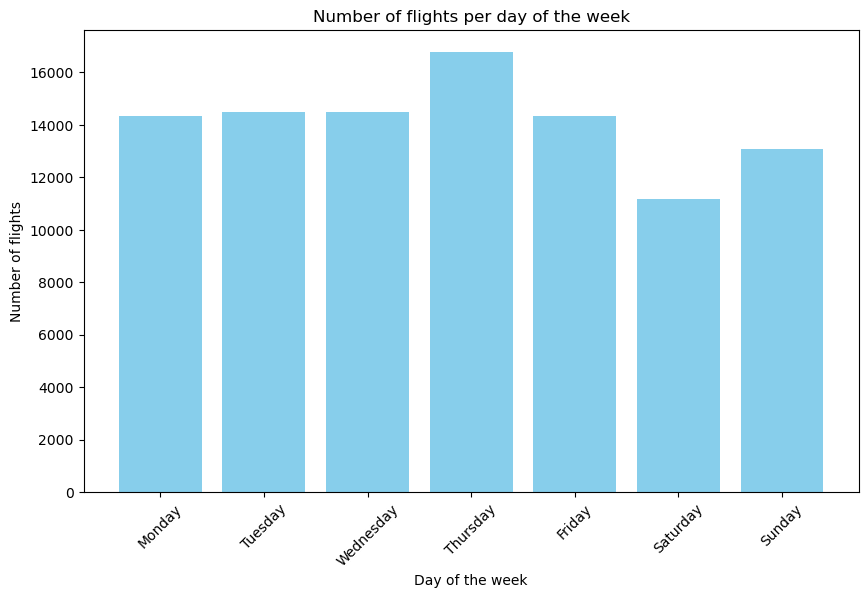

In [164]:
import matplotlib.pyplot as plta
plt.figure(figsize=(10,6))
plt.bar(pandas_df["Day of the week"], pandas_df["Number of flights"], color="skyblue")
plt.xlabel("Day of the week")
plt.ylabel("Number of flights")
plt.title("Number of flights per day of the week")
plt.xticks(rotation=45)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

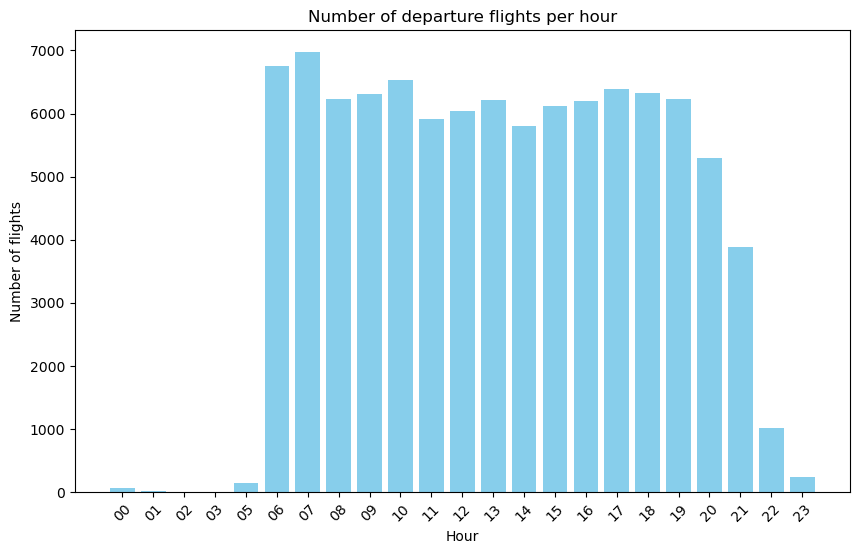

In [165]:
tmpFlightsDF = explFlightsDF.withColumn("Hour",F.lpad(F.col("DepTime"),4,"0").substr(1,2))

flights_per_hour = tmpFlightsDF.groupBy("Hour").count().orderBy("Hour")

pandas_df = flights_per_hour.toPandas()
pandas_df = pandas_df.rename(columns={"count": "Number of flights"})

plt.figure(figsize=(10,6))
plt.bar(pandas_df["Hour"], pandas_df["Number of flights"], color="skyblue")
plt.xlabel("Hour")
plt.ylabel("Number of flights")
plt.title("Number of departure flights per hour")
plt.xticks(rotation=45)
plt.show


In [166]:
pandas_expl_df = explFlightsDF.toPandas()

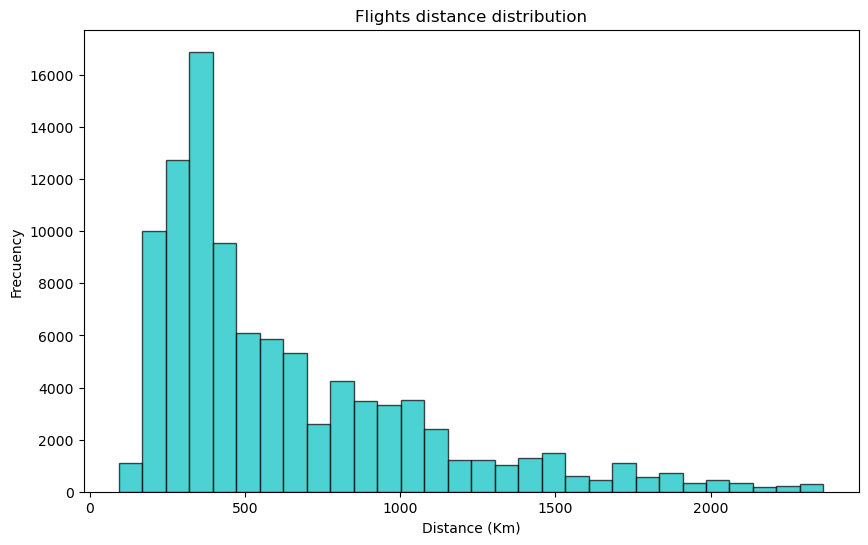

In [167]:


plt.figure(figsize=(10,6))

plt.hist(pandas_expl_df["Distance"], bins=30, color="c", edgecolor="k", alpha=0.7)
plt.xlabel("Distance (Km)")
plt.ylabel("Frecuency")
plt.title("Flights distance distribution")
plt.show()

In [168]:
delay_by_airline = explFlightsDF.groupBy("Origin").agg(F.avg("ArrDelay").alias("AverageArrivalDelay"), F.avg("DepDelay").alias("AverageDepartureDelay")).orderBy("AverageArrivalDelay")


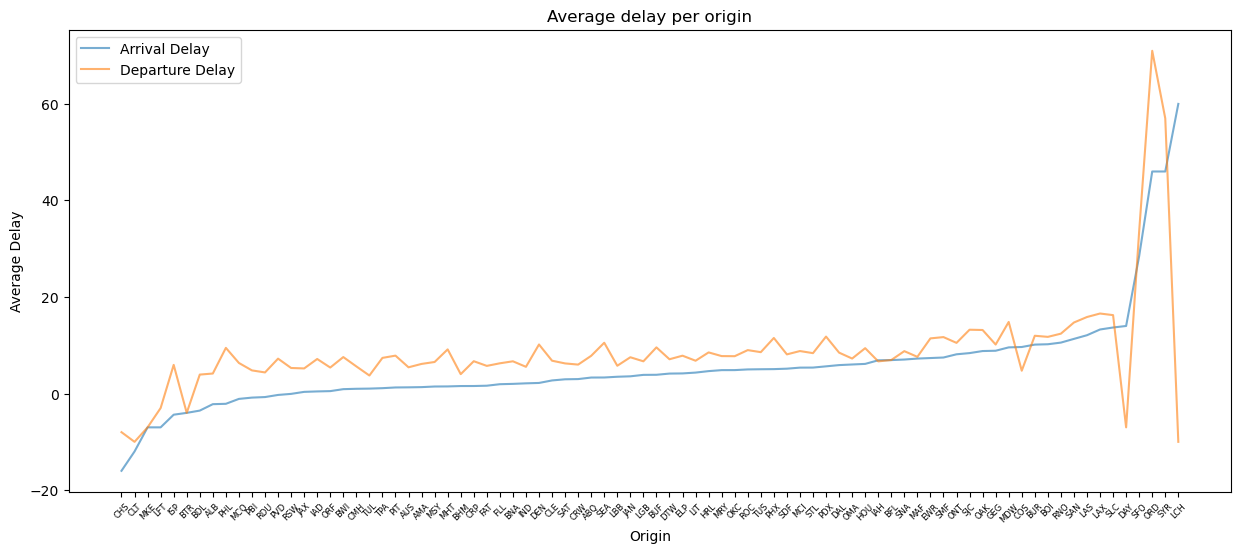

In [169]:
pandas_df = delay_by_airline.toPandas()



plt.figure(figsize=(15,6))
plt.plot(pandas_df["Origin"], pandas_df["AverageArrivalDelay"], alpha=0.6, label="Arrival Delay")
plt.plot(pandas_df["Origin"], pandas_df["AverageDepartureDelay"], alpha=0.6, label="Departure Delay")
plt.xlabel("Origin")
plt.ylabel("Average Delay")
plt.title("Average delay per origin")
plt.legend()
plt.xticks(rotation=45, fontsize=6)
plt.show()

In [170]:
# Calculamos el porcentaje de vuelos que caen en cada categoría de retraso
delayCategorizationDF.select("DelaySeverity", "ArrDelay")\
                     .groupBy("DelaySeverity")\
                     .agg(F.count("DelaySeverity").alias("NumFlights"), \
                          (F.count("DelaySeverity")/totalFlights*100).alias("Ratio"))\
                     .orderBy("DelaySeverity")\
                     .select("DelaySeverity","NumFlights",F.round("Ratio",2).alias("RoundedRatio")).show()

+--------------+----------+------------+
| DelaySeverity|NumFlights|RoundedRatio|
+--------------+----------+------------+
|     1.nodelay|     57143|        57.9|
|  2.acceptable|     22761|       23.06|
|    3.annoying|      8101|        8.21|
|   4.impactful|      6050|        6.13|
|5.unacceptable|      4643|         4.7|
+--------------+----------+------------+



Estadísticas de los vuelos con retraso severo

Para analizarlos solo nos quedamos con vuelos retrasados donde el retraso no es aceptable

In [177]:

severeDelaysDF = \
  delayCategorizationDF.where((F.col("DelaySeverity")!="1.nodelay") & (F.col("DelaySeverity")!="2.acceptable"))\
                       .select("DelaySeverity", "ArrDelay","CarrierDelay","WeatherDelay",\
                               "NASDelay", "SecurityDelay", "LateAircraftDelay")

severeDelaysDF.cache() # optimization


ret_delay = severeDelaysDF.groupBy("DelaySeverity")\
              .agg(F.avg("ArrDelay").alias("AverageDelay"),\
                   F.min("ArrDelay").alias("LowestDelay"),\
                   F.max("ArrDelay").alias("HighestDelay"),\
                   F.stddev("ArrDelay").alias("StdDevDelay"))\
              .orderBy("DelaySeverity")


mach_delay = severeDelaysDF.groupBy("DelaySeverity")\
              .agg(F.avg("CarrierDelay").alias("AverageDelay"),\
                   F.min("CarrierDelay").alias("LowestDelay"),\
                   F.max("CarrierDelay").alias("HighestDelay"),\
                   F.stddev("CarrierDelay").alias("StdDevDelay"))\
              .orderBy("DelaySeverity")


w__delay = severeDelaysDF.groupBy("DelaySeverity")\
              .agg(F.avg("WeatherDelay").alias("AverageDelay"),\
                   F.min("WeatherDelay").alias("LowestDelay"),\
                   F.max("WeatherDelay").alias("HighestDelay"),\
                   F.stddev("WeatherDelay").alias("StdDevDelay"))\
              .orderBy("DelaySeverity")

print("Estadísticas sobre el retraso de los vuelos (en minutos):")
ret_delay.show()
print("Estadísticas sobre el retraso debido al avión")
mach_delay.show()
print("Estadísticas sobre el retraso debido al tiempo atmosférico")
w__delay.show()

24/03/11 15:15:26 WARN CacheManager: Asked to cache already cached data.
Estadísticas sobre el retraso de los vuelos (en minutos):
+--------------+------------------+-----------+------------+------------------+
| DelaySeverity|      AverageDelay|LowestDelay|HighestDelay|       StdDevDelay|
+--------------+------------------+-----------+------------+------------------+
|    3.annoying| 21.97555857301568|         16|          30| 4.204130253081042|
|   4.impactful| 42.49900826446281|         31|          60| 8.490116530348118|
|5.unacceptable|112.50118457893603|         61|         500|55.535970510739816|
+--------------+------------------+-----------+------------+------------------+

Estadísticas sobre el retraso debido al avión
+--------------+-----------------+-----------+------------+-----------------+
| DelaySeverity|     AverageDelay|LowestDelay|HighestDelay|      StdDevDelay|
+--------------+-----------------+-----------+------------+-----------------+
|    3.annoying|5.3076163436

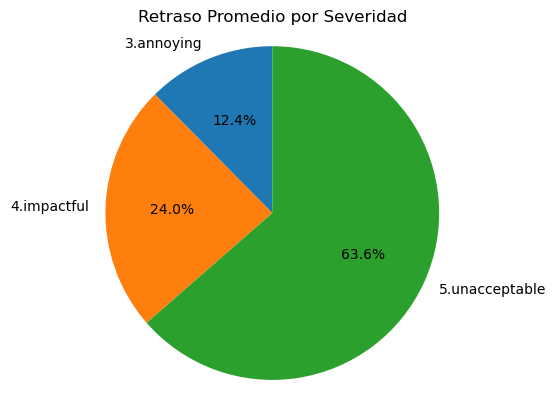

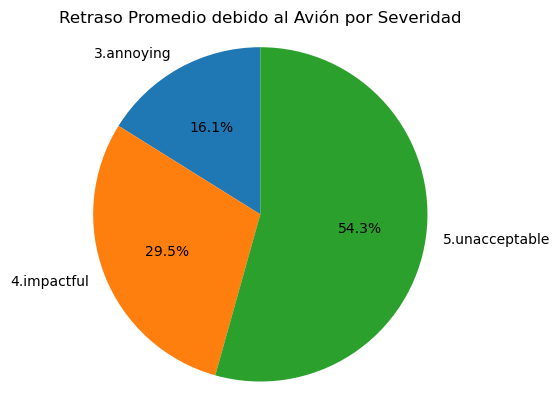

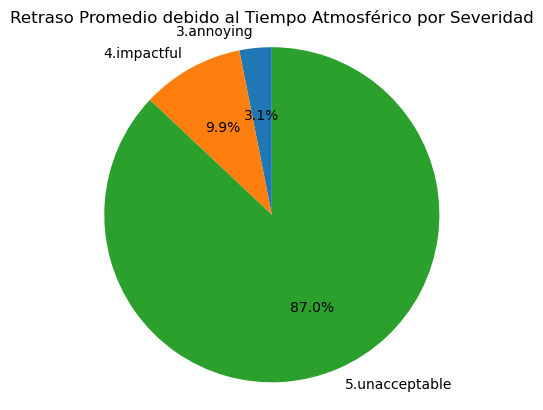

In [178]:
ret_delay_pd = ret_delay.toPandas()
mach_delay_pd = mach_delay.toPandas()
w__delay_pd = w__delay.toPandas()

def plot_pie_chart(df, title):
    fig, ax = plt.subplots()
    ax.pie(df['AverageDelay'], labels=df['DelaySeverity'], autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    plt.title(title)
    plt.show()

plot_pie_chart(ret_delay_pd, 'Retraso Promedio por Severidad')
plot_pie_chart(mach_delay_pd, 'Retraso Promedio debido al Avión por Severidad')
plot_pie_chart(w__delay_pd, 'Retraso Promedio debido al Tiempo Atmosférico por Severidad')


Ahora vemos el top 15 de aeropuertos involucrados en retrasos

In [188]:
totalFlightsOriginDF = delayCategorizationDF.groupBy("Origin").agg(F.count("ArrDelay").alias("TotalFlights"))

severeDelaysOriginDF = delayCategorizationDF \
                       .where((F.col("DelaySeverity")!="1.nodelay") & (F.col("DelaySeverity")!="2.acceptable"))\
                       .select("DelaySeverity", "ArrDelay","Origin")\
                       .groupBy("Origin", "DelaySeverity")\
                       .agg(F.count("ArrDelay").alias("NumSevereDelayedFlights"))

combinedDF = severeDelaysOriginDF.join(totalFlightsOriginDF, "Origin")\
     .withColumn("SevereDelayedRatio", F.round(F.col("NumSevereDelayedFlights")/F.col("TotalFlights")*100,2))\
     .orderBy(F.col("NumSevereDelayedFlights").desc())

combinedDF.cache()

print("Top 15 aeropuertos de origen con el porcentaje más alto de vuelos con retraso severo:")
combinedDF.limit(15).show(15)

print("Top 15 aeropuertos de origen por categoría de severidad")
combinedDF.groupBy("Origin").pivot("DelaySeverity").agg(F.min("SevereDelayedRatio"))\
   .orderBy(F.col("`5.unacceptable`").desc(), F.col("`4.impactful`").desc(), F.col("`3.annoying`").desc())\
   .limit(15).show(15)



24/03/11 15:39:04 WARN CacheManager: Asked to cache already cached data.
Top 15 aeropuertos de origen con el porcentaje más alto de vuelos con retraso severo:


+------+--------------+-----------------------+------------+------------------+
|Origin| DelaySeverity|NumSevereDelayedFlights|TotalFlights|SevereDelayedRatio|
+------+--------------+-----------------------+------------+------------------+
|   LAS|    3.annoying|                    743|        6728|             11.04|
|   LAS|   4.impactful|                    567|        6728|              8.43|
|   MDW|    3.annoying|                    562|        6215|              9.04|
|   PHX|    3.annoying|                    492|        5489|              8.96|
|   LAS|5.unacceptable|                    488|        6728|              7.25|
|   MDW|   4.impactful|                    470|        6215|              7.56|
|   MDW|5.unacceptable|                    429|        6215|               6.9|
|   OAK|    3.annoying|                    368|        3850|              9.56|
|   PHX|   4.impactful|                    363|        5489|              6.61|
|   LAX|    3.annoying|                 

+------+----------+-----------+--------------+
|Origin|3.annoying|4.impactful|5.unacceptable|
+------+----------+-----------+--------------+
|   SFO|      8.17|       6.88|         22.06|
|   SLC|      9.91|       7.94|          9.58|
|   BFL|      3.39|       5.08|          8.47|
|   LAX|     10.16|       9.49|          7.71|
|   SAN|       8.9|       8.69|          7.31|
|   LAS|     11.04|       8.43|          7.25|
|   EWR|      7.14|       7.14|          7.14|
|   MDW|      9.04|       7.56|           6.9|
|   GEG|     11.13|       5.64|          6.25|
|   OAK|      9.56|       7.92|          6.16|
|   RNO|      9.87|       7.52|          6.07|
|   BOI|     10.37|       6.97|          5.67|
|   FAT|      2.11|       4.23|          5.63|
|   COS|     12.78|       6.11|          5.56|
|   SJC|       8.2|       7.92|          5.42|
+------+----------+-----------+--------------+



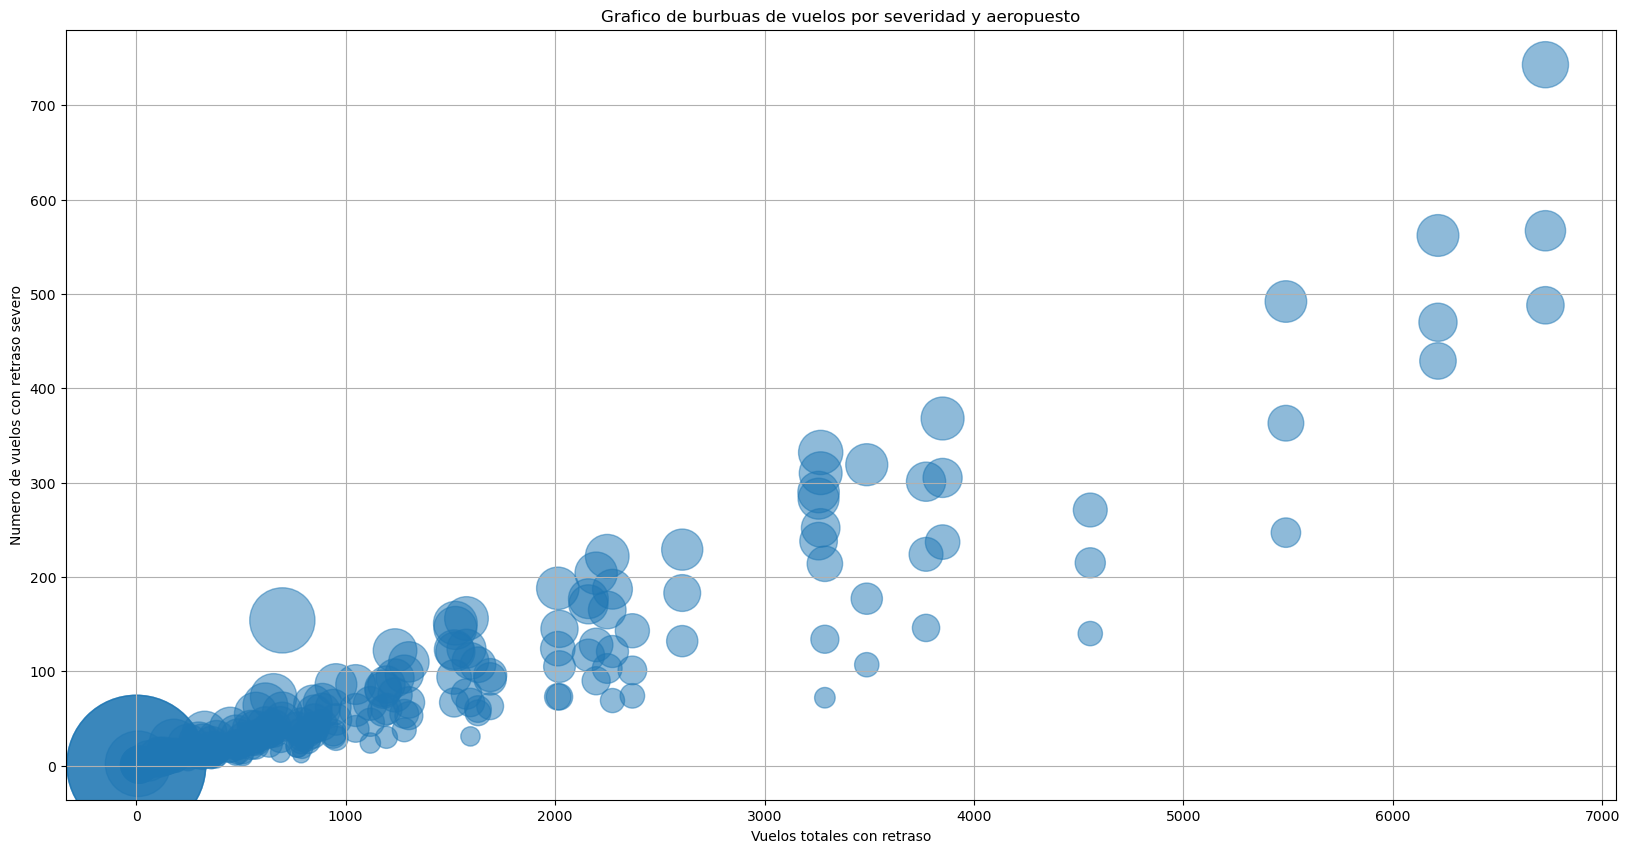

In [189]:
combined_pd = combinedDF.toPandas()
bubble_size = combined_pd['SevereDelayedRatio'] * 100  # Ajusta este valor según sea necesario

plt.figure(figsize=(20,10))

plt.scatter(combined_pd['TotalFlights'], combined_pd['NumSevereDelayedFlights'], s=bubble_size, alpha=0.5)
plt.xlabel('Vuelos totales con retraso')
plt.ylabel('Numero de vuelos con retraso severo')
plt.title('Grafico de burbuas de vuelos por severidad y aeropuesto')
plt.grid(True)
plt.show()

## Matriz de correlaciones

In [194]:
org_dest = explFlightsDF.select("Origin").union(explFlightsDF.select(F.col("Dest").alias("Origin"))).distinct()

indexer = StringIndexer(inputCol="Origin", outputCol="index")
org_dest_indexer = indexer.fit(org_dest).transform(org_dest)

#org_dest_indexer = org_dest_indexer.withColumn("index", F.col("index").cast(IntegerType()))
#org_dest_indexer.show(3)

explFlightsDF_indexes_origin = explFlightsDF.join(org_dest_indexer, "Origin", "left").withColumnRenamed("index","index_origin")

# explFlightsDF_indexes_origin.show()

explFlightsDF_indexes_origin_dest = explFlightsDF_indexes_origin.join(org_dest_indexer.withColumnRenamed("Origin","Dest"), "Dest", "left").withColumnRenamed("index","index_dest")
explFlightsDF_indexes_origin_dest.show(5)

+----+------+---------+-------+-------+--------+-------+--------+--------+------------+--------+-------------+-----------------+------------+------------+----------+
|Dest|Origin|DayOfWeek|TailNum|DepTime|DepDelay|ArrTime|ArrDelay|Distance|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|CarrierDelay|index_origin|index_dest|
+----+------+---------+-------+-------+--------+-------+--------+--------+------------+--------+-------------+-----------------+------------+------------+----------+
| TPA|   IAD|        4| N712SW|   2003|       8|   2211|     -14|     810|        null|    null|         null|             null|        null|        35.0|      86.0|
| TPA|   IAD|        4| N772SW|    754|      19|   1002|       2|     810|        null|    null|         null|             null|        null|        35.0|      86.0|
| BWI|   IND|        4| N428WN|    628|       8|    804|      14|     515|        null|    null|         null|             null|        null|        37.0|      13.0|
| BW

In [198]:
columns = explFlightsDF_indexes_origin_dest.drop("TailNum","Dest","Origin").columns
columns

['DayOfWeek',
 'DepTime',
 'DepDelay',
 'ArrTime',
 'ArrDelay',
 'Distance',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'CarrierDelay',
 'index_origin',
 'index_dest']

In [202]:
null_counts = [explFlightsDF_indexes_origin_dest.where(F.col(c).isNull()).count() for c in explFlightsDF_indexes_origin_dest.columns]

na_counts = [explFlightsDF_indexes_origin_dest.where(F.col(c) == "NA").count() for c in explFlightsDF_indexes_origin_dest.columns]

for i, col_name in enumerate(explFlightsDF_indexes_origin_dest.columns):
    print(f"Columna '{col_name}': Valores nulos: {null_counts[i]}, Valores NA: {na_counts[i]}")
    
explFlightsDF_indexes_origin_dest.printSchema()

Columna 'Dest': Valores nulos: 0, Valores NA: 0
Columna 'Origin': Valores nulos: 0, Valores NA: 0
Columna 'DayOfWeek': Valores nulos: 0, Valores NA: 0
Columna 'TailNum': Valores nulos: 0, Valores NA: 0
Columna 'DepTime': Valores nulos: 0, Valores NA: 0
Columna 'DepDelay': Valores nulos: 0, Valores NA: 0
Columna 'ArrTime': Valores nulos: 0, Valores NA: 0
Columna 'ArrDelay': Valores nulos: 0, Valores NA: 0
Columna 'Distance': Valores nulos: 0, Valores NA: 0
Columna 'WeatherDelay': Valores nulos: 79069, Valores NA: 0
Columna 'NASDelay': Valores nulos: 79069, Valores NA: 0
Columna 'SecurityDelay': Valores nulos: 79069, Valores NA: 0
Columna 'LateAircraftDelay': Valores nulos: 79069, Valores NA: 0
Columna 'CarrierDelay': Valores nulos: 79069, Valores NA: 0
Columna 'index_origin': Valores nulos: 0, Valores NA: 0
Columna 'index_dest': Valores nulos: 0, Valores NA: 0
root
 |-- Dest: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Ta

In [ ]:
explFlightsDF_indexes_origin_dest = explFlightsDF_indexes_origin_dest

In [201]:
assembler = VectorAssembler(inputCols=columns, outputCol="features")

df_vector = assembler.transform(explFlightsDF_indexes_origin_dest).select("features")

matrix = Correlation.corr(df_vector, "features").head()

correlation_matrix = matrix[0].toArray()

print("Correlation_matrix:\n", correlation_matrix)

Correlation_matrix:
 [[ 1.          0.03111076  0.0982202   0.02194688  0.08529901  0.01752531
          nan         nan         nan         nan         nan  0.00235733
   0.00164833]
 [ 0.03111076  1.          0.25725889  0.79690258  0.23241529 -0.05684925
          nan         nan         nan         nan         nan  0.01308286
   0.01214039]
 [ 0.0982202   0.25725889  1.          0.0911642   0.9422735   0.00968305
          nan         nan         nan         nan         nan  0.03883576
   0.02932398]
 [ 0.02194688  0.79690258  0.0911642   1.          0.07635281  0.02467485
          nan         nan         nan         nan         nan  0.01800977
   0.01216676]
 [ 0.08529901  0.23241529  0.9422735   0.07635281  1.         -0.08141473
          nan         nan         nan         nan         nan  0.03223838
   0.03056958]
 [ 0.01752531 -0.05684925  0.00968305  0.02467485 -0.08141473  1.
          nan         nan         nan         nan         nan  0.02722666
   0.02689245]
 [       

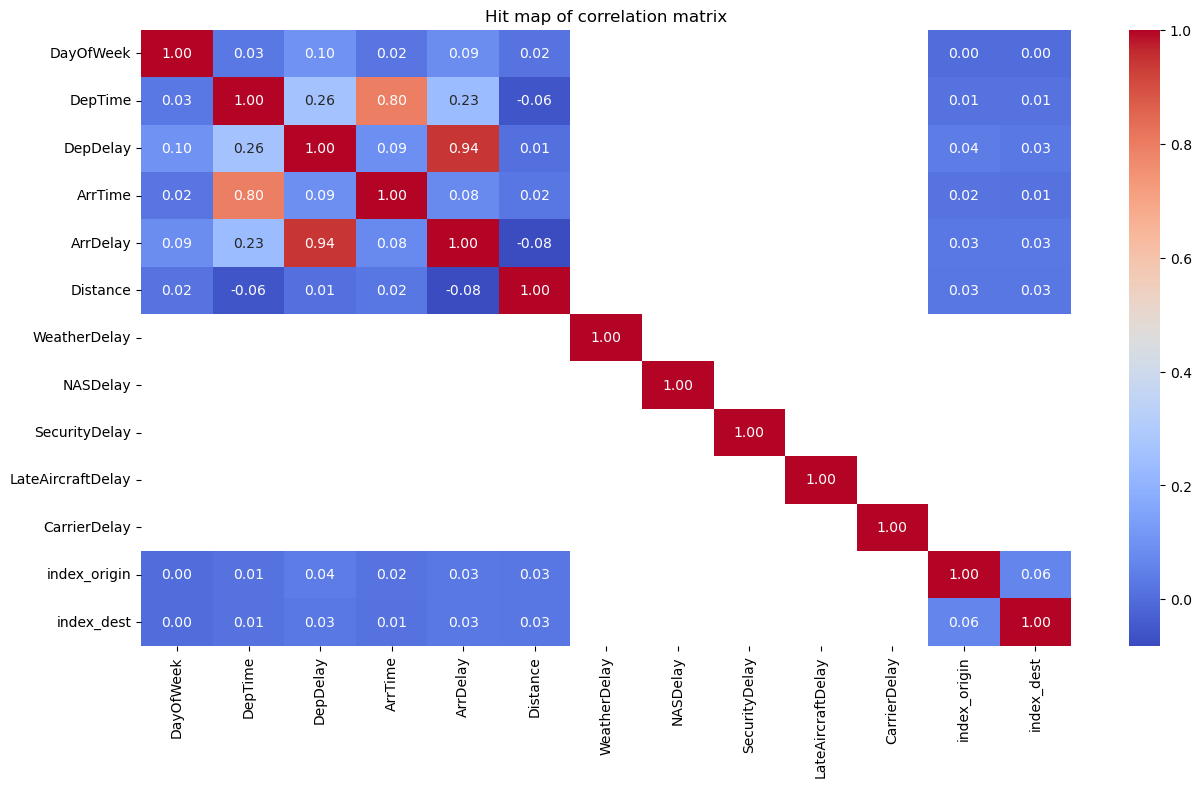

In [203]:
plt.figure(figsize=(15,8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=columns, yticklabels=columns)
plt.title("Hit map of correlation matrix")
plt.show()

# Persistencia del EDA

Para posteriormente probar el correcto funcionamiento del modelo, vamos a separar los datos en un 90% (para entrenar y testear el modelo) y un 10 % (para validarlo posteriormente). 

In [39]:
train_test_df, validation_df = cleanFlightsDF.randomSplit([0.9, 0.1], seed=42)

num_filas = train_test_df.count()
print("Número de filas datos train y test:", num_filas)

num_filas = validation_df.count()
print("Número de filas datos validación:", num_filas)

# Guardar los nuevos conjuntos de datos como archivos CSV
train_test_df.coalesce(1).write.mode("overwrite").option("header", "true").csv("Train_test_data", header=True)
validation_df.coalesce(1).write.mode("overwrite").option("header", "true").csv("Validation_data", header=True)

Número de filas datos train y test: 88827


Número de filas datos validación: 9871


In [19]:
cleanFlightsDF.coalesce(1).write.option("header", "true").csv("Data")


[Stage 242:>                                                        (0 + 1) / 1]



# IGNORAR ESTAS TRANSFORMACIONES, SE HARÁN SOLO EN EL DATASET DE TRAIN EN AZURE ML

Categorizamos las columnas de **TailNum**, **Origin** y **Dest** para convertirlos en categorías de numeros reales enteros (Integers).

In [20]:
TailNumIndexed = StringIndexer(inputCol = "TailNum", outputCol="TailNumIndexed", handleInvalid="skip")
originIndexer = StringIndexer(inputCol = "Origin", outputCol="OriginIndexed", handleInvalid="skip")
destIndexer = StringIndexer(inputCol = "Dest", outputCol="DestIndexed", handleInvalid="skip")

indexed = TailNumIndexed.fit(cleanFlightsDF).transform(cleanFlightsDF)
indexed = originIndexer.fit(indexed).transform(indexed)
indexed = destIndexer.fit(indexed).transform(indexed)


[Stage 243:>                                                        (0 + 3) / 3]



In [21]:
cleanFlightsDF = indexed.select("DayOfWeek", "TailNumIndexed", "OriginIndexed", "DestIndexed", "DepTime", "DepDelay", "ArrTime", "ArrDelay")

In [22]:
cleanFlightsDF.printSchema()

root
 |-- DayOfWeek: integer (nullable = true)
 |-- TailNumIndexed: double (nullable = false)
 |-- OriginIndexed: double (nullable = false)
 |-- DestIndexed: double (nullable = false)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)



In [23]:
cleanFlightsDF.show()

+---------+--------------+-------------+-----------+-------+--------+-------+--------+
|DayOfWeek|TailNumIndexed|OriginIndexed|DestIndexed|DepTime|DepDelay|ArrTime|ArrDelay|
+---------+--------------+-------------+-----------+-------+--------+-------+--------+
|        4|         461.0|         61.0|       12.0|   2003|       8|   2211|     -14|
|        4|         236.0|         61.0|       12.0|    754|      19|   1002|       2|
|        4|         175.0|         50.0|        3.0|    628|       8|    804|      14|
|        4|          56.0|         50.0|        3.0|    926|      -4|   1054|      -6|
|        4|         313.0|         50.0|        3.0|   1829|      34|   1959|      34|
|        4|         292.0|         50.0|       37.0|   1940|      25|   2121|      11|
|        4|         177.0|         50.0|        0.0|   1937|      67|   2037|      57|
|        4|         175.0|         50.0|        0.0|   1039|      -1|   1132|     -18|
|        4|          45.0|         50.0|   

Para simplificar el modelo y reducir dimensionalidad, vamos a categorizar las variables **ArrDelay** y **DepTime**. Para cada una de estas variables diferenciaremos las siguientes categorías:

- **ArrDelay**: Definimos tres categorías: <15 (0), entre 15 y 60 (1) y >60 (2)
- **DepTime**: Definimos varias franjas: 00:00 - 06:00 (0), 06:00 - 12:00 (1), 12:00 - 18:00 (2), 18:00 - 22:00 (3), 22:00 - 00:00 (4)

In [24]:
splitsDelays = [-float("inf"), 15, 60, float("inf")]
arrDelayBucketizer = Bucketizer(splits=splitsDelays, inputCol="ArrDelay", outputCol="ArrDelayBucketed")

splitsDepTime = [-1, 600, 1200, 1800, 2200, 2500]
depTimeBucketizer = Bucketizer(splits=splitsDepTime, inputCol="DepTime", outputCol="DepTimeBucketed")

bucketized = arrDelayBucketizer.transform(cleanFlightsDF)
bucketized = depTimeBucketizer.transform(bucketized)

In [25]:
cleanFlightsDF = bucketized.select("DayOfWeek", "TailNumIndexed", "OriginIndexed", "DestIndexed", "DepTimeBucketed", "DepDelay", "ArrTime", "ArrDelayBucketed")

In [26]:
cleanFlightsDF.printSchema()

root
 |-- DayOfWeek: integer (nullable = true)
 |-- TailNumIndexed: double (nullable = false)
 |-- OriginIndexed: double (nullable = false)
 |-- DestIndexed: double (nullable = false)
 |-- DepTimeBucketed: double (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- ArrDelayBucketed: double (nullable = true)



In [27]:
cleanFlightsDF.show()

+---------+--------------+-------------+-----------+---------------+--------+-------+----------------+
|DayOfWeek|TailNumIndexed|OriginIndexed|DestIndexed|DepTimeBucketed|DepDelay|ArrTime|ArrDelayBucketed|
+---------+--------------+-------------+-----------+---------------+--------+-------+----------------+
|        4|         461.0|         61.0|       12.0|            3.0|       8|   2211|             0.0|
|        4|         236.0|         61.0|       12.0|            1.0|      19|   1002|             0.0|
|        4|         175.0|         50.0|        3.0|            1.0|       8|    804|             0.0|
|        4|          56.0|         50.0|        3.0|            1.0|      -4|   1054|             0.0|
|        4|         313.0|         50.0|        3.0|            3.0|      34|   1959|             1.0|
|        4|         292.0|         50.0|       37.0|            3.0|      25|   2121|             0.0|
|        4|         177.0|         50.0|        0.0|            3.0|     